In [1]:
!sudo apt-get install -y xvfb ffmpeg
!pip install -q gym
!pip install -q 'imageio==2.4.0'
!pip install -q PILLOW
!pip install -q pyglet
!pip install -q pyvirtualdisplay
!pip install -q tf-agents

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
The following NEW packages will be installed:
  xvfb
0 upgraded, 1 newly installed, 0 to remove and 14 not upgraded.
Need to get 784 kB of archives.
After this operation, 2,270 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.8 [784 kB]
Fetched 784 kB in 1s (839 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected pack

##DQN Solution

Reference \\
https://www.tensorflow.org/agents/tutorials/1_dqn_tutorial \\
https://github.com/openai/gym/wiki/MountainCar-v0 \\
https://github.com/openai/gym/blob/master/gym/envs/classic_control/mountain_car.py

In [2]:
from __future__ import absolute_import, division, print_function

import os
import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay
import gym
import math

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.environments import gym_wrapper
from tf_agents.environments import wrappers

from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import q_network
from tf_agents.policies import random_tf_policy
from tf_agents.policies import policy_saver
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

from gym import spaces
from gym.utils import seeding
from gym.envs.classic_control import MountainCarEnv 

tf.compat.v1.enable_v2_behavior()

# Set up a virtual display for rendering OpenAI gym environments.
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
class ChangeRewardMountainCarEnv(MountainCarEnv):
  def __init__(self, goal_velocity=0):
     super(ChangeRewardMountainCarEnv, self).__init__(goal_velocity=goal_velocity)
  
  def step(self, action):
    assert self.action_space.contains(action), "%r (%s) invalid" % (action, type(action))

    position, velocity = self.state
    #### Changed reward
    past_reward = 100*(np.sin(3 * position) * 0.0025 + 0.5 * velocity * velocity)

    velocity += (action - 1) * self.force + math.cos(3 * position) * (-self.gravity)
    velocity = np.clip(velocity, -self.max_speed, self.max_speed)
    position += velocity
    position = np.clip(position, self.min_position, self.max_position)
    if position == self.min_position and velocity < 0:
      velocity = 0

    done = bool(
      position >= self.goal_position and velocity >= self.goal_velocity
    )
    #### Changed reward
    now_reward = 100*(np.sin(3 * position) * 0.0025 + 0.5 * velocity * velocity)
    reward = now_reward - past_reward
    if done:
      reward += 1

    self.state = (position, velocity)
    return np.array(self.state), reward, done, {}

In [5]:
def RL_train(train_env, eval_env, fc_layer_params=(48,64,), name='train'):

  global agent, random_policy, returns, steps

  # Q Network
  q_net = q_network.QNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params,
    )
  
  # Optimizer
  optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

  # DQN Agent
  train_step_counter = tf.Variable(0)
  agent = dqn_agent.DqnAgent(
      train_env.time_step_spec(),
      train_env.action_spec(),
      q_network=q_net,
      optimizer=optimizer,
      td_errors_loss_fn=common.element_wise_squared_loss,
      gamma = 0.99,
      target_update_tau = 0.005,
      train_step_counter=train_step_counter,
      )
  agent.initialize()

  # Policy
  eval_policy = agent.policy
  collect_policy = agent.collect_policy
  random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(), train_env.action_spec())

  # Replay Buffer
  replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)
  
  # Collect Data
  collect_data(train_env, agent.policy, replay_buffer, initial_collect_steps)

  # Data Pipeline
  dataset = replay_buffer.as_dataset(
    num_parallel_calls=4, 
    sample_batch_size=batch_size, 
    num_steps=2).prefetch(4)
  iterator = iter(dataset)

  # Trajectory
  time_step = train_env.current_time_step()
  action_step = agent.collect_policy.action(time_step)
  next_time_step = train_env.step(action_step.action)
  traj = trajectory.from_transition(time_step, action_step, next_time_step)
  replay_buffer.add_batch(traj)

  # Reset the train step
  agent.train_step_counter.assign(0)

  # Evaluate the agent's policy once before training.
  avg_return, avg_step = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
  returns = [avg_return]
  steps = [avg_step]

  # Train the Policy
  for _ in range(num_iterations):

    # Collect a few steps using collect_policy and save to the replay buffer.
    collect_data(train_env, agent.collect_policy, replay_buffer, collect_steps_per_iteration)

    # Sample a batch of data from the buffer and update the agent's network.
    experience, unused_info = next(iterator)
    train_loss = agent.train(experience).loss

    step = agent.train_step_counter.numpy()

    if step % log_interval == 0:
      print('step = {0}: loss = {1}'.format(step, train_loss))

    if step % eval_interval == 0:
      avg_return, avg_step = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
      print('step = {0}: Average Return = {1}, Average Steps = {2}'.format(step, avg_return, avg_step))
      returns.append(avg_return)
      steps.append(avg_step)
  
  # Save the Agent and Policy
  checkpoint_dir = os.path.join(tempdir, 'checkpoint' + name)
  global_step = tf.compat.v1.train.get_or_create_global_step()
  train_checkpointer = common.Checkpointer(
      ckpt_dir=checkpoint_dir,
      max_to_keep=1,
      agent=agent,
      policy=agent.policy,
      replay_buffer=replay_buffer,
      global_step=global_step
  )
  policy_dir = os.path.join(tempdir, 'policy' + name)
  tf_policy_saver = policy_saver.PolicySaver(agent.policy)
  train_checkpointer.save(global_step)
  tf_policy_saver.save(policy_dir)



In [6]:
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  total_count = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0
    episode_count = 0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
      episode_count += 1
    total_count += episode_count
    total_return += episode_return

  avg_count = total_count / num_episodes
  avg_return = total_return / num_episodes
  
  return avg_return.numpy()[0], avg_count

def collect_step(environment, policy, buffer):
  time_step = environment.current_time_step()
  action_step = policy.action(time_step)
  next_time_step = environment.step(action_step.action)
  traj = trajectory.from_transition(time_step, action_step, next_time_step)

  # Add trajectory to the replay buffer
  buffer.add_batch(traj)

def collect_data(env, policy, buffer, steps):
  for _ in range(steps):
    collect_step(env, policy, buffer)

def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

def create_policy_eval_video(policy, filename, num_episodes=5, fps=30):
  filename = filename + ".mp4"
  with imageio.get_writer(filename, fps=fps) as video:
    for _ in range(num_episodes):
      time_step = eval_env.reset()
      video.append_data(eval_py_env.render())
      while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = eval_env.step(action_step.action)
        video.append_data(eval_py_env.render())
  return embed_mp4(filename)

In [7]:
num_iterations = 100000 # @param {type:"integer"}

initial_collect_steps = 100  # @param {type:"integer"} 
collect_steps_per_iteration = 1  # @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size = 256  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 200  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}

tempdir = '/content/drive/MyDrive/5242/Project' # @param {type:"string"}

In [ ]:
#env_name = 'MountainCar-v0'
#train_py_env = suite_gym.load(env_name)
#eval_py_env = suite_gym.load(env_name)
#train_env = tf_py_environment.TFPyEnvironment(train_py_env)
#eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

In [8]:
train_py_env = gym_wrapper.GymWrapper(
      ChangeRewardMountainCarEnv(),
      discount=1,
      spec_dtype_map=None,
      auto_reset=True,
      render_kwargs=None,
  )
eval_py_env = gym_wrapper.GymWrapper(
      ChangeRewardMountainCarEnv(),
      discount=1,
      spec_dtype_map=None,
      auto_reset=True,
      render_kwargs=None,
  )
train_py_env = wrappers.TimeLimit(train_py_env, duration=200)
eval_py_env = wrappers.TimeLimit(eval_py_env, duration=200)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

In [ ]:
RL_train(train_env, eval_env, fc_layer_params = (48,64,), name = '_train')

step = 200: loss = 1.3414547765933094e-06
step = 400: loss = 3.7264776437950786e-06
step = 600: loss = 9.052867426362354e-06
step = 800: loss = 4.281483597878832e-06
step = 1000: loss = 3.645983451860957e-05
step = 1000: Average Return = 1.5919243097305298, Average Steps = 143.1
step = 1200: loss = 7.751574594294652e-05
step = 1400: loss = 6.203709199326113e-05
step = 1600: loss = 0.00024409094476141036
step = 1800: loss = 2.398382275714539e-05
step = 2000: loss = 0.0003003773745149374
step = 2000: Average Return = 1.534740686416626, Average Steps = 128.2
step = 2200: loss = 0.00028685637516900897
step = 2400: loss = 0.00010421282786410302
step = 2600: loss = 0.00023894741025287658
step = 2800: loss = 0.00039721428765915334
step = 3000: loss = 0.00048898218665272
step = 3000: Average Return = 0.6657218933105469, Average Steps = 194.3
step = 3200: loss = 0.0003271727473475039
step = 3400: loss = 0.0002109940251102671
step = 3600: loss = 4.964150139130652e-05
step = 3800: loss = 0.000484

INFO:tensorflow:Assets written to: /content/drive/MyDrive/5242/project/policy_train/assets


Set num_iterations to 50000+ will let agent converge to less than 110 steps

Text(0.5, 0, 'Iterations')

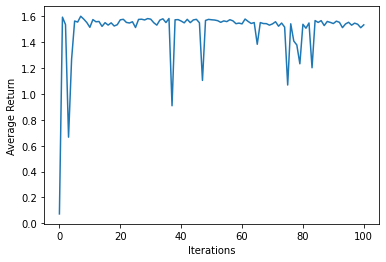

In [ ]:
iterations = range(len(returns))
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')

Text(0.5, 0, 'Iterations')

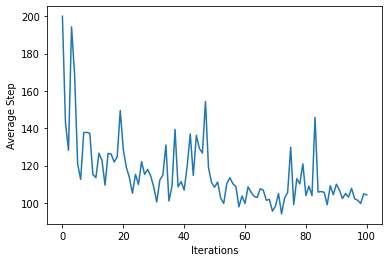

In [ ]:
iterations = range(len(steps))
plt.plot(iterations, steps)
plt.ylabel('Average Step')
plt.xlabel('Iterations')

In [9]:
policy_dir = os.path.join(tempdir, 'policy' + '_train')
saved_policy = tf.compat.v2.saved_model.load(policy_dir)
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(), train_env.action_spec())

In [ ]:
create_policy_eval_video(saved_policy, "trained-agent", 5, 60)

In [10]:
N = 200
now_reward, now_step = compute_avg_return(eval_env, saved_policy, N)
print('Average reward for %d consecutive trials: %f' %(N, now_reward))
print('Average step for %d consecutive trials: %f' %(N, now_step))

Average reward for 200 consecutive trials: 1.536497
Average step for 200 consecutive trials: 103.565000


In [ ]:
create_policy_eval_video(random_policy, "random-agent", 5, 60)

## Numerical Solution

Reference \\
https://github.com/ZhiqingXiao/OpenAIGymSolution/blob/master/MountainCar-v0_close_form/mountaincar_v0_close_form.ipynb

In [13]:
from tf_agents.policies import actor_policy
from tf_agents.networks import network

In [14]:
class NoNet(network.Network):

  def __init__(self, input_tensor_spec, output_tensor_spec):
    super(NoNet, self).__init__(
        input_tensor_spec=input_tensor_spec,
        state_spec=(),
        name='NoNet')

  def call(self, observations, step_type, network_state):
    del step_type
    actions = []
    for i in range(observations.shape[0]):
      position, velocity = observations[i]
      lb = min(-0.09 * (position + 0.25) ** 2 + 0.03,
              0.3 * (position + 0.9) ** 4 - 0.008)
      ub = -0.07 * (position + 0.38) ** 2 + 0.07
      if lb < velocity < ub:
          action = [2] # push right
      else:
          action = [0] # push left
      actions += action
    actions = tf.cast(actions, tf.int64)
    # Scale and shift actions to the correct range if necessary.
    return actions, network_state

In [15]:
# Original environment without changing reward
env_name = 'MountainCar-v0'
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

In [16]:
action_net = NoNet(train_env.time_step_spec()[3], train_env.action_spec())

my_actor_policy = actor_policy.ActorPolicy(
    time_step_spec=train_env.time_step_spec(),
    action_spec=train_env.action_spec(),
    actor_network=action_net)

eval_env.reset()
policy = my_actor_policy
time_step = train_env.current_time_step()
action_step = policy.action(time_step)
time_step = eval_env.step(action_step.action)

In [20]:
N = 200
now_reward, now_step = compute_avg_return(eval_env, my_actor_policy, N)
print('Average reward for %d consecutive trials: %f' %(N, now_reward))
print('Average step for %d consecutive trials: %f' %(N, now_step))

Average reward for 200 consecutive trials: -107.480003
Average step for 200 consecutive trials: 107.480000


In [ ]:
create_policy_eval_video(my_actor_policy, "numerical-agent", 5, 60)

## Changed Environment

In [2]:
class NewMountainCarEnv(MountainCarEnv):
  def __init__(self, goal_velocity=0):
    super(NewMountainCarEnv, self).__init__(goal_velocity=goal_velocity)
    self.min_position = -2
    self.left_position = -1.2
    self.middle_position = np.pi/2
    self.max_position = 5
    self.max_speed = 0.2
    self.goal_position = 4.7
    self.goal_velocity = goal_velocity

  def _cal_ypos(self, x):
    if x < self.left_position:
      return 3 * (x-self.left_position) * np.cos(3*self.left_position) + np.sin(3*self.left_position)
    elif x < self.middle_position:
      return np.sin(3*x)
    else:
      return -3*np.sin(x) + 2
  
  def step(self, action):
    assert self.action_space.contains(action), "%r (%s) invalid" % (action, type(action))

    position, velocity = self.state
    #### Changed reward
    past_reward = 100*(self._cal_ypos(position) * 0.0025 + 0.5 * velocity * velocity)

    if position < self.left_position:
      velocity += (action - 1) * self.force + math.cos(3 * self.left_position) * (-self.gravity)
    elif position < self.middle_position:
      velocity += (action - 1) * self.force + math.cos(3 * position) * (-self.gravity)
    else:
      velocity += (action - 1) * self.force - math.cos(position) * (-self.gravity)
    velocity = np.clip(velocity, -self.max_speed, self.max_speed)
    position += velocity
    position = np.clip(position, self.min_position, self.max_position)

    if (position == self.min_position and velocity < 0):
        velocity = 0

    done = bool(
        position >= self.goal_position and velocity >= self.goal_velocity
    )
    #### Changed reward
    now_reward = 100*(self._cal_ypos(position) * 0.0025 + 0.5 * velocity * velocity)

    reward = now_reward - past_reward
    if done:
      reward += 5

    self.state = (position, velocity)
    return np.array(self.state), reward, done, {}
  
  def reset(self):
    self.state = np.array([self.np_random.uniform(low=-0.8, high=-0.2), 0])
    return np.array(self.state)

  def _height(self, xs):
    try:
      ys = []
      for s in xs:
        ys += [self._cal_ypos(s) * .45 + .55]
      return np.asarray(ys)
    except:
      return self._cal_ypos(xs) * .45 + .55
  
  def render(self, mode='human'):
    screen_width = 600
    screen_height = 400

    world_width = self.max_position - self.min_position
    scale = screen_width / world_width
    carwidth = 20
    carheight = 10

    if self.viewer is None:
      from gym.envs.classic_control import rendering
      self.viewer = rendering.Viewer(screen_width, screen_height)
      xs = np.linspace(self.min_position, self.max_position, 300)
      ys = self._height(xs)
      xys = list(zip((xs - self.min_position) * scale, ys * scale))

      self.track = rendering.make_polyline(xys)
      self.track.set_linewidth(4)
      self.viewer.add_geom(self.track)

      clearance = 5

      l, r, t, b = -carwidth / 2, carwidth / 2, carheight, 0
      car = rendering.FilledPolygon([(l, b), (l, t), (r, t), (r, b)])
      car.add_attr(rendering.Transform(translation=(0, clearance)))
      self.cartrans = rendering.Transform()
      car.add_attr(self.cartrans)
      self.viewer.add_geom(car)
      frontwheel = rendering.make_circle(carheight / 2.5)
      frontwheel.set_color(.5, .5, .5)
      frontwheel.add_attr(
          rendering.Transform(translation=(carwidth / 4, clearance))
      )
      frontwheel.add_attr(self.cartrans)
      self.viewer.add_geom(frontwheel)
      backwheel = rendering.make_circle(carheight / 2.5)
      backwheel.add_attr(
          rendering.Transform(translation=(-carwidth / 4, clearance))
      )
      backwheel.add_attr(self.cartrans)
      backwheel.set_color(.5, .5, .5)
      self.viewer.add_geom(backwheel)
      flagx = (self.goal_position-self.min_position) * scale
      flagy1 = self._height(self.goal_position) * scale
      flagy2 = flagy1 + 50
      flagpole = rendering.Line((flagx, flagy1), (flagx, flagy2))
      self.viewer.add_geom(flagpole)
      flag = rendering.FilledPolygon(
          [(flagx, flagy2), (flagx, flagy2 - 10), (flagx + 25, flagy2 - 5)]
      )
      flag.set_color(.8, .8, 0)
      self.viewer.add_geom(flag)

    pos = self.state[0]
    self.cartrans.set_translation(
        (pos-self.min_position) * scale, self._height(pos) * scale
    )
    if pos < self.left_position:
      rotate = math.cos(3 * self.left_position)
    elif pos < self.middle_position:
      rotate = math.cos(3 * pos)
    else:
      rotate = -math.cos(pos)
    self.cartrans.set_rotation(rotate)

    return self.viewer.render(return_rgb_array=mode == 'rgb_array')


In [3]:
train_py_env = gym_wrapper.GymWrapper(
      NewMountainCarEnv(),
      discount=1,
      spec_dtype_map=None,
      auto_reset=True,
      render_kwargs=None,
  )
eval_py_env = gym_wrapper.GymWrapper(
      NewMountainCarEnv(),
      discount=1,
      spec_dtype_map=None,
      auto_reset=True,
      render_kwargs=None,
  )
train_py_env = wrappers.TimeLimit(train_py_env, duration=500)
eval_py_env = wrappers.TimeLimit(eval_py_env, duration=500)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

In [12]:
num_iterations = 100000 # @param {type:"integer"}

In [13]:
RL_train(train_env, eval_env, fc_layer_params=(48,64,), name = '_modify')

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


step = 200: loss = 5.340007191989571e-07
step = 400: loss = 9.407711331732571e-06
step = 600: loss = 2.4304463295266032e-05
step = 800: loss = 0.0005003753467462957
step = 1000: loss = 0.000280925800325349
step = 1000: Average Return = 6.760180473327637, Average Steps = 231.8
step = 1200: loss = 0.0003420203283894807
step = 1400: loss = 0.001155615784227848
step = 1600: loss = 0.00041403109207749367
step = 1800: loss = 0.000434961577411741
step = 2000: loss = 0.00024959829170256853
step = 2000: Average Return = 4.644474983215332, Average Steps = 455.8
step = 2200: loss = 0.00036548482603393495
step = 2400: loss = 0.0006026638438925147
step = 2600: loss = 0.0003338546957820654
step = 2800: loss = 0.01110123097896576
step = 3000: loss = 0.00034151197178289294
step = 3000: Average Return = 3.9535152912139893, Average Steps = 380.6
step = 3200: loss = 0.0006257526110857725
step = 3400: loss = 0.002077618846669793
step = 3600: loss = 0.002212386578321457
step = 3800: loss = 0.01166775077581

INFO:tensorflow:Assets written to: /content/drive/MyDrive/5242/project/policy_modify/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/5242/project/policy_modify/assets


Text(0.5, 0, 'Iterations')

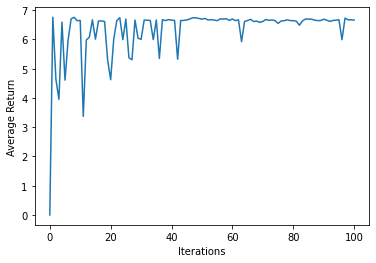

In [14]:
iterations = range(len(returns))
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')

Text(0.5, 0, 'Iterations')

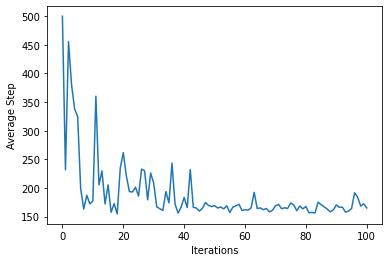

In [15]:
iterations = range(len(steps))
plt.plot(iterations, steps)
plt.ylabel('Average Step')
plt.xlabel('Iterations')

In [13]:
policy_dir = os.path.join(tempdir, 'policy' + '_modify')
saved_policy = tf.compat.v2.saved_model.load(policy_dir)

In [9]:
create_policy_eval_video(saved_policy, "new-environment-agent", 5, 60)

In [19]:
N = 200
now_reward, now_step = compute_avg_return(eval_env, saved_policy, N)
print('Average reward for %d consecutive trials: %f' %(N, now_reward))
print('Average step for %d consecutive trials: %f' %(N, now_step))

Average reward for 200 consecutive trials: 6.654375
Average step for 200 consecutive trials: 164.650000
